In [3]:
import numpy as np
import pandas as pd
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten, Conv1D, Convolution1D, \
                         MaxPooling1D, GlobalAveragePooling1D, Reshape, CuDNNLSTM, CuDNNGRU, Concatenate, Input, LSTM, Layer
from keras.layers.wrappers import Bidirectional
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
# from bettertensorboard import TrainValTensorBoard
import os
%config InlineBackend.figure_format = 'retina'

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
K.tensorflow_backend._get_available_gpus()

[]

# Loading the data

In [6]:
def to_onehot(sequences, alphabet='ACGT'):
    sequences_onehot = []
    for seq in sequences:
        seq_onehot = np.zeros((len(seq), len(alphabet)), dtype=int)
        for i in range(len(seq)):
            seq_onehot[i, alphabet.index(seq[i])] = 1
        sequences_onehot.append(seq_onehot)
    return sequences_onehot

In [7]:
# X = np.load('data/X.npy')
# y = np.load('data/y.npy')

In [12]:
data_dir = '../../data/'
dataset_filename = 'cn34_lm1a_te.csv'
rna_alphabet = 'A C G T N'.split()

In [13]:
data = pd.read_csv(data_dir + dataset_filename)
data.head()

FileNotFoundError: [Errno 2] File b'../../data/cn34_lm1a_te.csv' does not exist: b'../../data/cn34_lm1a_te.csv'

In [8]:
# X = np.array([list(i) for i in data['Sequence'].values])
X = to_onehot(data['Sequence'].values)
# max_len = np.max([len(X[i]) for i in range(X.shape[0])])
# X_all = np.array([list(i * max_len) for i in rna_alphabet])

In [13]:
len(X)

11182

In [12]:
X[0].shape

(4732, 4)

In [14]:
X[0][:15]

array([[1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])

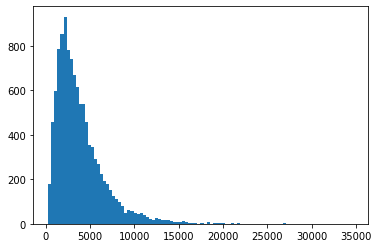

In [16]:
plt.hist([len(X[i]) for i in range(len(X))], bins=100);

In [17]:
# for i in range(X.shape[0]):
#     X[i] = X[i] + ['N'] * (max_len - len(X[i]))

In [18]:
# X = np.array([i for i in X])

In [19]:
# X.shape

In [20]:
# one_hot_encoder = OneHotEncoder(sparse=False, dtype=np.uint8)
# one_hot_encoder.fit(X_all)

In [21]:
# X = one_hot_encoder.transform(X)

In [22]:
# X = X.reshape(-1, max_len, len(rna_alphabet))

In [23]:
# X = X[:, :, (0, 1, 2, 4)]  # remove Ns
# X.shape

In [24]:
y = data['TE'].values.reshape(-1, 1)
y.shape

(11182, 1)

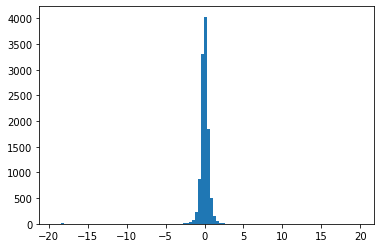

In [25]:
plt.hist(y, bins=100);

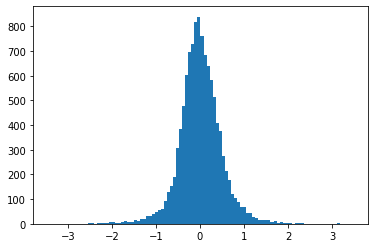

In [26]:
plt.hist(y[np.abs(y) < 5], bins=100);

In [27]:
# np.save('data/X.npy', X)
# np.save('data/y.npy', y)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2)

In [80]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [81]:
early_stopping = EarlyStopping(monitor='val_r_square', patience=10, verbose=1, mode='auto')

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [82]:
def plot_history(history, metric):
    plt.figure(figsize=(16, 6));
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1);
    plt.plot(history.history[metric]);
    plt.plot(history.history['val_' + metric]);
    plt.title('Model ' + metric);
    plt.ylabel(metric);
    plt.xlabel('Epoch');
    plt.legend(['Train', 'Test'], loc='best');

    # Plot training & validation loss values
    plt.subplot(1, 2, 2);
    plt.plot(history.history['loss']);
    plt.plot(history.history['val_loss']);
    plt.title('Model loss');
    plt.ylabel('Loss');
    plt.xlabel('Epoch');
    plt.legend(['Train', 'Test'], loc='best');

In [83]:
class RiboSeqGenerator(keras.utils.Sequence):

    def __init__(self, x, y, batch_size=32):
        self.x, self.y = x, y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = pad_sequences(batch_x, dtype=int, padding='post')

        return batch_x, batch_y

# Training Models

In [40]:
tensorboard = TrainValTensorBoard()

## DeepBind

In [71]:
def create_deepbind(input_shape):
    """
    DeepBind model by Alipanahi et al. 2015
    """
    x = Input(shape=input_shape)

    cnn = Conv1D(filters=64, kernel_size=24)(x)
    cnn = BatchNormalization()(cnn)
    cnn = Activation('relu')(cnn)
    cnn = GlobalAveragePooling1D()(cnn)

    y = Dense(32)(cnn)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Dense(1)(y)
    y = BatchNormalization()(y)
    y = Activation('linear')(y)

    return Model(inputs=x, outputs=y)

In [72]:
deepbind = create_deepbind((None, 4))
deepbind.compile(optimizer='nadam', loss=rmse, metrics=[r_square])
deepbind.summary()
# plot_model(cnn, show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, None, 4)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 64)          6208      
_________________________________________________________________
batch_normalization_16 (Batc (None, None, 64)          256       
_________________________________________________________________
activation_16 (Activation)   (None, None, 64)          0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_17 (Batc (None, 32)                128       
__________

In [74]:
deepbind_history = deepbind.fit_generator(generator=RiboSeqGenerator(X_train, y_train),
                                          validation_data=RiboSeqGenerator(X_val, y_val),
                                          epochs=10,
                                          use_multiprocessing=True,
                                          workers=32)

Epoch 1/10
280/280 [==============================] - 31s 110ms/step - loss: 0.7159 - r_square: -0.0995 - val_loss: 0.8179 - val_r_square: -0.0111
Epoch 2/10
280/280 [==============================] - 28s 99ms/step - loss: 0.6997 - r_square: -0.0149 - val_loss: 0.8166 - val_r_square: 7.3509e-05
Epoch 3/10
280/280 [==============================] - 27s 96ms/step - loss: 0.6963 - r_square: 0.0035 - val_loss: 0.8170 - val_r_square: -0.0035
Epoch 4/10
280/280 [==============================] - 26s 94ms/step - loss: 0.6961 - r_square: 0.0033 - val_loss: 0.8149 - val_r_square: 0.0101
Epoch 5/10
280/280 [==============================] - 27s 96ms/step - loss: 0.6958 - r_square: 0.0062 - val_loss: 0.8192 - val_r_square: -0.0136
Epoch 6/10
280/280 [==============================] - 27s 95ms/step - loss: 0.6958 - r_square: 0.0047 - val_loss: 0.8152 - val_r_square: 0.0096
Epoch 7/10
280/280 [==============================] - 28s 100ms/step - loss: 0.6952 - r_square: 0.0081 - val_loss: 0.8157 - va

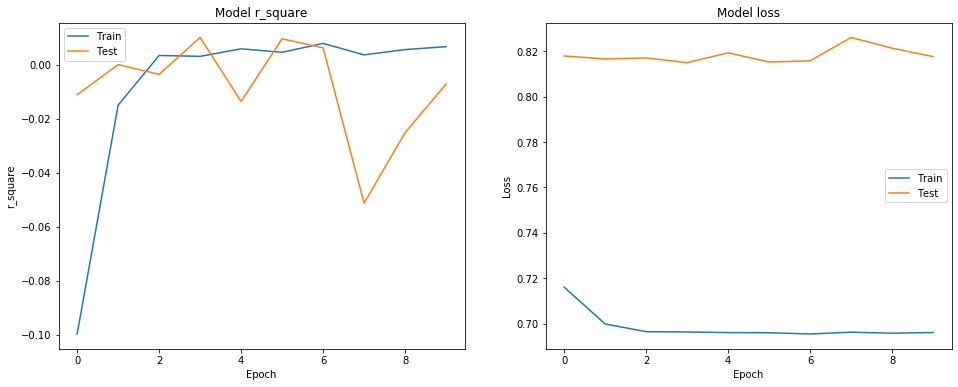

In [77]:
plot_history(deepbind_history, 'r_square')
plt.show();

## Deeper DeepBind

In [92]:
def create_deeper_deepbind(input_shape):
    """
    Simply the DeepBind (Alipanahi et al. 2015) but with deeper convolutional layers
    """
    x = Input(shape=input_shape)

    cnn = Conv1D(filters=256, kernel_size=8)(x)
    cnn = BatchNormalization()(cnn)
    cnn = Activation('relu')(cnn)
    cnn = MaxPooling1D(pool_size=4)(cnn)
    
    cnn = Conv1D(filters=256, kernel_size=8)(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Activation('relu')(cnn)
    cnn = MaxPooling1D(pool_size=4)(cnn)
    
    cnn = Conv1D(filters=256, kernel_size=8)(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Activation('relu')(cnn)
    cnn = GlobalAveragePooling1D()(cnn)

    y = Dense(64)(cnn)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Dense(1)(y)
    y = BatchNormalization()(y)
    y = Activation('linear')(y)

    return Model(inputs=x, outputs=y)

In [93]:
deeper_deepbind = create_deeper_deepbind((None, 4))
deeper_deepbind.compile(optimizer='nadam', loss=rmse, metrics=[r_square])
deeper_deepbind.summary()
# plot_model(cnn, show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, None, 4)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, None, 256)         8448      
_________________________________________________________________
batch_normalization_35 (Batc (None, None, 256)         1024      
_________________________________________________________________
activation_35 (Activation)   (None, None, 256)         0         
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, None, 256)         0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, None, 256)         524544    
_________________________________________________________________
batch_normalization_36 (Batc (None, None, 256)         1024      
__________

In [94]:
batch_size = 32
deeper_deepbind_history = deeper_deepbind.fit_generator(generator=RiboSeqGenerator(X_train, y_train, batch_size),
                                                        validation_data=RiboSeqGenerator(X_val, y_val, batch_size),
                                                        epochs=20,
                                                        use_multiprocessing=True,
                                                        workers=8)

Epoch 1/20
223/224 [============================>.] - ETA: 0s - loss: 1.1358 - r_square: -2.4834

224/224 [==============================] - 171s 762ms/step - loss: 1.1334 - r_square: -2.4801 - val_loss: 0.9266 - val_r_square: -2.4794
Epoch 2/20
224/224 [==============================] - 55s 248ms/step - loss: 0.8681 - r_square: -0.5343 - val_loss: 0.6809 - val_r_square: -0.6250
Epoch 3/20
224/224 [==============================] - 56s 248ms/step - loss: 0.7658 - r_square: 0.0160 - val_loss: 0.6235 - val_r_square: -0.2734
Epoch 6/20
224/224 [==============================] - 56s 249ms/step - loss: 0.7651 - r_square: 0.0188 - val_loss: 0.6977 - val_r_square: -0.7174
Epoch 6/20
Epoch 7/20
224/224 [==============================] - 56s 248ms/step - loss: 0.7636 - r_square: 0.0227 - val_loss: 0.7051 - val_r_square: -0.7606
Epoch 8/20
224/224 [==============================] - 56s 248ms/step - loss: 0.7663 - r_square: 0.0104 - val_loss: 0.5707 - val_r_square: -0.0121
Epoch 9/20
224/224 [===

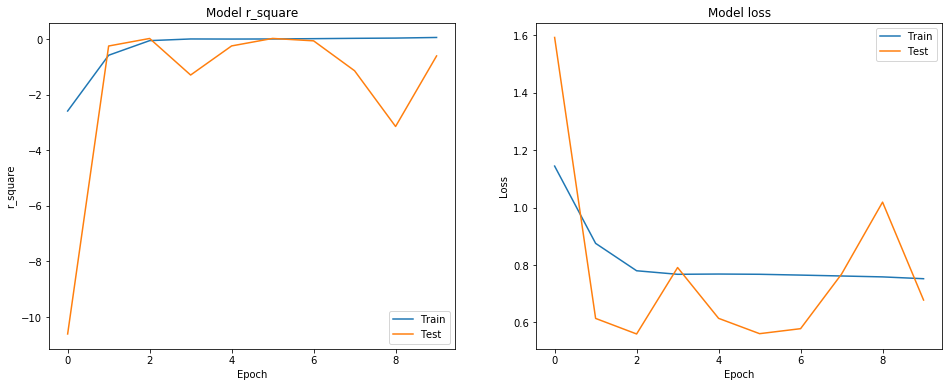

In [91]:
plot_history(deeper_deepbind_history, 'r_square')
plt.show();

## RNN

In [61]:
def create_rnn(input_shape):
    """
    a Bidirectional LSTM model which predicts from the sequence only
    """
    x = Input(shape=input_shape)

    rnn = Bidirectional(CuDNNLSTM(units=100, return_sequences=False))(x)

    y = Dense(64)(rnn)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(1)(y)
    y = BatchNormalization()(y)
    y = Activation('linear')(y)

    return Model(inputs=x, outputs=y)

In [62]:
rnn = create_rnn((None, 4))
rnn.compile(optimizer='rmsprop', loss=rmse, metrics=[r_square])
rnn.summary()
# plot_model(rnn, show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, 4)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 200)               84800     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                12864     
_________________________________________________________________
batch_normalization_9 (Batch (None, 64)                256       
_________________________________________________________________
activation_9 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
__________

In [63]:
rnn_history = rnn.fit_generator(generator=training_generator,
                                validation_data=test_generator,
                                epochs=3,
                                use_multiprocessing=True,
                                workers=32)

Epoch 1/3
 31/280 [==>...........................] - ETA: 6:33 - loss: 1.2297 - r_square: -4.7161

Process ForkPoolWorker-240:
Process ForkPoolWorker-242:
Process ForkPoolWorker-251:
Process ForkPoolWorker-249:
Process ForkPoolWorker-230:
Process ForkPoolWorker-229:
Process ForkPoolWorker-245:
Process ForkPoolWorker-235:
Process ForkPoolWorker-250:
Process ForkPoolWorker-239:
Process ForkPoolWorker-215:
Process ForkPoolWorker-197:
Process ForkPoolWorker-207:
Process ForkPoolWorker-234:
Process ForkPoolWorker-219:
Process ForkPoolWorker-247:
Process ForkPoolWorker-209:
Process ForkPoolWorker-248:
Process ForkPoolWorker-212:
Process ForkPoolWorker-226:
Process ForkPoolWorker-227:
Process ForkPoolWorker-231:
Process ForkPoolWorker-206:
Process ForkPoolWorker-203:
Process ForkPoolWorker-201:
Process ForkPoolWorker-210:
Process ForkPoolWorker-224:
Process ForkPoolWorker-200:
Process ForkPoolWorker-232:
Process ForkPoolWorker-217:
Process ForkPoolWorker-204:
Process ForkPoolWorker-214:
Process ForkPoolWorker-193:
Process ForkPoolWorker-196:
Process ForkPoolWorker-202:
Process ForkPoolWork

KeyboardInterrupt: 

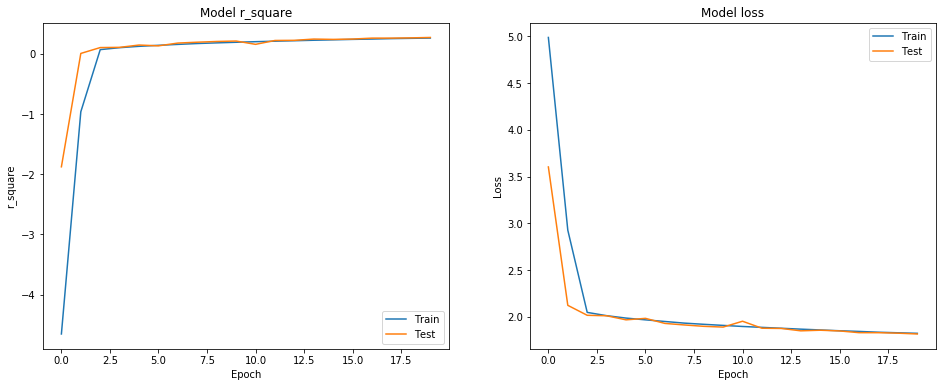

In [ ]:
plot_history(rnn_history, 'r_square')
plt.show();

It will go up to 0.36 of $R^2$.

## Fixed Dilated CNN

In [21]:
class FixedDilatedCNN(Layer):
    """
    This layer takes a tensor in shape (n_samples, rna_length, 4) and returns a
    tensor in shape (n_samples, rna_length, n_structural_features)

    It uses a kind of dilated CNN with no trainable parameters to extract the
    RNA structural features
    """

    def __init__(self, dilation_start=2, dilation_end=None, n_bulge=2, **kwargs):
        self.dilation_start = dilation_start
        self.dilation_end = dilation_end
        self.n_bulge = n_bulge
        self.n_dilations = None
        super(FixedDilatedCNN, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.dilation_end is None:
            self.dilation_end = int(input_shape[1] / 2 - 1)
        self.n_dilations = self.dilation_end - self.dilation_start
        super(FixedDilatedCNN, self).build(input_shape)

    def call(self, x):
        result = []

        for s in range(self.dilation_start, self.dilation_end):
            x_padded_left = K.temporal_padding(x, (s+1, 0))
            x_padded_right = K.temporal_padding(x, (0, s+1))
            dilation = x_padded_right[:, s+1:, :] * x_padded_left[:, :-(s+1), ::-1]
            dilation = dilation * np.array([[2, 3, 3, 2]]).reshape((1, 1, 4))
            dilation = K.sum(dilation, axis=2)
            result.append(dilation)

            for d in range(1, self.n_bulge+1):
                # left bulges
                x_padded_left = K.temporal_padding(x, (s+1+d, 0))
                x_padded_right = K.temporal_padding(x, (0, s+1))
                dilation = x_padded_right[:, s+1:, :] * x_padded_left[:, :-(s+1+d), ::-1]
                dilation = dilation * np.array([[2, 3, 3, 2]]).reshape((1, 1, 4))
                dilation = K.sum(dilation, axis=2)
                result.append(dilation)
            for d in range(1, self.n_bulge+1):
                # right bulges
                x_padded_left = K.temporal_padding(x, (s+1, 0))
                x_padded_right = K.temporal_padding(x, (0, s+1+d))
                dilation = x_padded_right[:, s+1+d:, :] * x_padded_left[:, :-(s+1), ::-1]
                dilation = dilation * np.array([[2, 3, 3, 2]]).reshape((1, 1, 4))
                dilation = K.sum(dilation, axis=2)
                result.append(dilation)
 
        result = K.stack(result)
        result = K.permute_dimensions(result, (1, 2, 0))
#         result = K.permute_dimensions(result, (1, 2, 0, 3))
#         result = K.reshape(result, (-1, result.shape[1], result.shape[2] * result.shape[3]))
        return result

    def compute_output_shape(self, input_shape):
#         return (input_shape[0], input_shape[1], self.n_dilations * (self.n_bulge * 2 + 1) * 4)
        return (input_shape[0], input_shape[1], self.n_dilations * (self.n_bulge * 2 + 1))

## Fixed Dilated CNN + CNN

In [19]:
def create_fixed_dilated_cnn(input_shape):
    x = Input(shape=input_shape)
    x_dilated = FixedDilatedCNN(dilation_start=2)(x)

    cnn1 = Conv1D(filters=64, kernel_size=16, padding='same')(x)
    cnn1 = BatchNormalization()(cnn1)
    cnn1 = Activation('relu')(cnn1)
    cnn1 = MaxPooling1D(pool_size=2)(cnn1)

    cnn1 = Conv1D(filters=64, kernel_size=10, padding='same')(cnn1)
    cnn1 = BatchNormalization()(cnn1)
    cnn1 = Activation('relu')(cnn1)
    cnn1 = MaxPooling1D(pool_size=2)(cnn1)

    cnn1 = Conv1D(filters=64, kernel_size=5)(cnn1)
    cnn1 = BatchNormalization()(cnn1)
    cnn1 = Activation('relu')(cnn1)
    cnn1 = MaxPooling1D(pool_size=4)(cnn1)

    cnn2 = Conv1D(filters=64, kernel_size=12)(x_dilated)
    cnn2 = BatchNormalization()(cnn2)
    cnn2 = Activation('relu')(cnn2)
    cnn2 = MaxPooling1D(pool_size=2)(cnn2)

    cnn2 = Conv1D(filters=64, kernel_size=7)(cnn2)
    cnn2 = BatchNormalization()(cnn2)
    cnn2 = Activation('relu')(cnn2)
    cnn2 = MaxPooling1D(pool_size=2)(cnn2)

    cnn2 = Conv1D(filters=64, kernel_size=5)(cnn2)
    cnn2 = BatchNormalization()(cnn2)
    cnn2 = Activation('relu')(cnn2)
    cnn2 = MaxPooling1D(pool_size=2)(cnn2)

    flat = Concatenate()([Flatten()(cnn1), Flatten()(cnn2)])

    y = Dense(64)(flat)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(32)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(1)(y)
    y = BatchNormalization()(y)
    y = Activation('linear')(y)

    return Model(inputs=x, outputs=y)

In [20]:
fixed_dilated_cnn = create_fixed_dilated_cnn(X_train.shape[1:])
fixed_dilated_cnn.compile(optimizer='adam', loss=rmse, metrics=[r_square])
fixed_dilated_cnn.summary()
# plot_model(fixed_dilated_cnn, show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50, 4)        0                                            
__________________________________________________________________________________________________
fixed_dilated_cnn_3 (FixedDilat (None, 50, 110)      0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 50, 64)       4160        input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 39, 64)       84544       fixed_dilated_cnn_3[0][0]        
__________________________________________________________________________________________________
batch_norm

In [21]:
fdcnn_history = fixed_dilated_cnn.fit(X_train, y_train, batch_size=256, epochs=100, validation_split=.2)

Train on 640000 samples, validate on 160000 samples
Epoch 1/100
640000/640000 [==============================] - 91s 142us/step - loss: 4.9888 - r_square: -4.6325 - val_loss: 3.9523 - val_r_square: -2.4996
Epoch 2/100
640000/640000 [==============================] - 86s 135us/step - loss: 2.8457 - r_square: -0.8592 - val_loss: 2.0707 - val_r_square: 0.0401
Epoch 3/100
640000/640000 [==============================] - 86s 135us/step - loss: 1.7191 - r_square: 0.3422 - val_loss: 1.5642 - val_r_square: 0.4522
Epoch 4/100
640000/640000 [==============================] - 86s 135us/step - loss: 1.5620 - r_square: 0.4582 - val_loss: 1.5153 - val_r_square: 0.4854
Epoch 5/100
640000/640000 [==============================] - 86s 135us/step - loss: 1.5080 - r_square: 0.4949 - val_loss: 1.4882 - val_r_square: 0.5039
Epoch 6/100
640000/640000 [==============================] - 86s 135us/step - loss: 1.4693 - r_square: 0.5202 - val_loss: 1.4424 - val_r_square: 0.5338
Epoch 7/100
640000/640000 [======

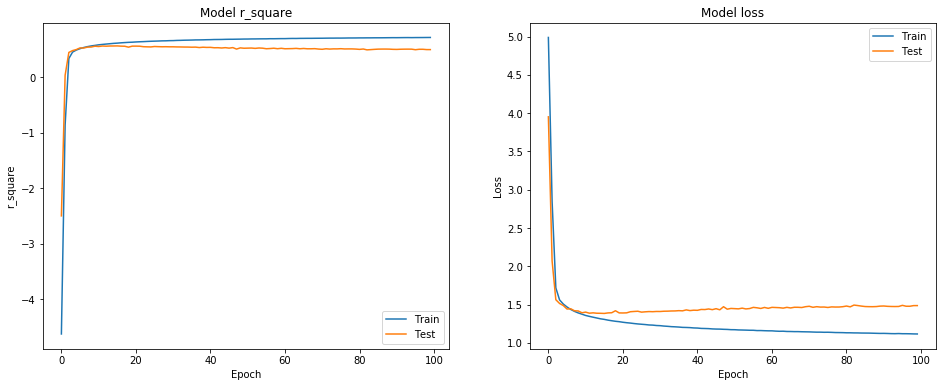

In [22]:
plot_history(fdcnn_history, 'r_square')
plt.show();

## Fixed Dilated CNN + RNN

In [22]:
def create_fixed_dilated_cnn_rnn(input_shape):
    x = Input(shape=input_shape)
    x_dilated = FixedDilatedCNN(dilation_start=2)(x)

    rnn1 = Bidirectional(CuDNNLSTM(units=32, return_sequences=True))(x)

    rnn1 = Bidirectional(CuDNNLSTM(units=16, return_sequences=True))(rnn1)
    
    rnn2 = Bidirectional(CuDNNLSTM(units=32, return_sequences=True))(x_dilated)
    
    rnn2 = Bidirectional(CuDNNLSTM(units=16, return_sequences=True))(rnn2)

    flat = Concatenate()([Flatten()(rnn1), Flatten()(rnn2)])

    y = Dense(32)(flat)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(32)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(1)(y)
    y = BatchNormalization()(y)
    y = Activation('linear')(y)

    return Model(inputs=x, outputs=y)

In [23]:
fixed_dilated_cnn_rnn = create_fixed_dilated_cnn_rnn(X_train.shape[1:])
fixed_dilated_cnn_rnn.compile(optimizer='rmsprop', loss=rmse, metrics=[r_square])
fixed_dilated_cnn_rnn.summary()
# plot_model(fixed_dilated_cnn, show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50, 4)        0                                            
__________________________________________________________________________________________________
fixed_dilated_cnn_2 (FixedDilat (None, 50, 110)      0           input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 50, 64)       9728        input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 50, 64)       36864       fixed_dilated_cnn_2[0][0]        
__________________________________________________________________________________________________
bidirectio

In [28]:
fdcnn_rnn_history = fixed_dilated_cnn_rnn.fit(X_train, y_train, batch_size=256, epochs=200, validation_split=.2,
                                             callbacks=[tensorboard], initial_epoch=68)

Train on 640000 samples, validate on 160000 samples
Epoch 69/200
640000/640000 [==============================] - 115s 179us/step - loss: 1.2256 - r_square: 0.6659 - val_loss: 1.2477 - val_r_square: 0.6537
Epoch 70/200
640000/640000 [==============================] - 114s 179us/step - loss: 1.2236 - r_square: 0.6669 - val_loss: 1.2219 - val_r_square: 0.6673
Epoch 71/200
351232/640000 [===============>..............] - ETA: 46s - loss: 1.2176 - r_square: 0.6705

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 116s 181us/step - loss: 1.2211 - r_square: 0.6683 - val_loss: 1.2708 - val_r_square: 0.6406
Epoch 76/200
640000/640000 [==============================] - 115s 179us/step - loss: 1.2209 - r_square: 0.6684 - val_loss: 1.2368 - val_r_square: 0.6593
Epoch 77/200
158464/640000 [======>.......................] - ETA: 1:19 - loss: 1.2099 - r_square: 0.6743

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 114s 179us/step - loss: 1.2178 - r_square: 0.6699 - val_loss: 1.2401 - val_r_square: 0.6573
Epoch 82/200
640000/640000 [==============================] - 116s 181us/step - loss: 1.2161 - r_square: 0.6710 - val_loss: 1.2374 - val_r_square: 0.6591
Epoch 83/200
148992/640000 [=====>........................] - ETA: 1:19 - loss: 1.2093 - r_square: 0.6752

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



607744/640000 [===========================>..] - ETA: 5s - loss: 1.2142 - r_square: 0.6719

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 110s 172us/step - loss: 1.2127 - r_square: 0.6728 - val_loss: 1.2326 - val_r_square: 0.6615
Epoch 88/200
640000/640000 [==============================] - 110s 172us/step - loss: 1.2126 - r_square: 0.6731 - val_loss: 1.2319 - val_r_square: 0.6620
Epoch 89/200
321024/640000 [==============>...............] - ETA: 48s - loss: 1.2092 - r_square: 0.6758

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 109s 170us/step - loss: 1.2076 - r_square: 0.6757 - val_loss: 1.2375 - val_r_square: 0.6591
Epoch 93/200
 36608/640000 [>.............................] - ETA: 1:37 - loss: 1.1957 - r_square: 0.6824

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 113s 177us/step - loss: 1.2088 - r_square: 0.6750 - val_loss: 1.2498 - val_r_square: 0.6524
Epoch 94/200
640000/640000 [==============================] - 110s 172us/step - loss: 1.2089 - r_square: 0.6749 - val_loss: 1.2553 - val_r_square: 0.6491
Epoch 95/200
289536/640000 [============>.................] - ETA: 55s - loss: 1.2026 - r_square: 0.6786

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 113s 177us/step - loss: 1.2072 - r_square: 0.6758 - val_loss: 1.2781 - val_r_square: 0.6362
Epoch 99/200
196096/640000 [========>.....................] - ETA: 1:08 - loss: 1.1994 - r_square: 0.6802

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 111s 173us/step - loss: 1.2070 - r_square: 0.6759 - val_loss: 1.2409 - val_r_square: 0.6569
Epoch 100/200
640000/640000 [==============================] - 113s 176us/step - loss: 1.2053 - r_square: 0.6769 - val_loss: 1.2366 - val_r_square: 0.6595
Epoch 101/200
233216/640000 [=========>....................] - ETA: 1:06 - loss: 1.2016 - r_square: 0.6798

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 117s 183us/step - loss: 1.2031 - r_square: 0.6780 - val_loss: 1.2914 - val_r_square: 0.6287
Epoch 105/200
419840/640000 [==================>...........] - ETA: 35s - loss: 1.1973 - r_square: 0.6796

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 114s 179us/step - loss: 1.2041 - r_square: 0.6773 - val_loss: 1.2424 - val_r_square: 0.6564
Epoch 107/200
 60672/640000 [=>............................] - ETA: 1:30 - loss: 1.1961 - r_square: 0.6802

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 111s 174us/step - loss: 1.2005 - r_square: 0.6794 - val_loss: 1.2420 - val_r_square: 0.6566
Epoch 110/200
640000/640000 [==============================] - 112s 175us/step - loss: 1.2009 - r_square: 0.6792 - val_loss: 1.2253 - val_r_square: 0.6654
Epoch 111/200
169984/640000 [======>.......................] - ETA: 1:16 - loss: 1.1959 - r_square: 0.6810

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 114s 178us/step - loss: 1.2003 - r_square: 0.6794 - val_loss: 1.2647 - val_r_square: 0.6439
Epoch 113/200
 54528/640000 [=>............................] - ETA: 1:33 - loss: 1.1902 - r_square: 0.6853

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 111s 173us/step - loss: 1.1973 - r_square: 0.6811 - val_loss: 1.2337 - val_r_square: 0.6611
Epoch 116/200
575744/640000 [=========================>....] - ETA: 10s - loss: 1.1975 - r_square: 0.6812

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



436224/640000 [===================>..........] - ETA: 32s - loss: 1.1945 - r_square: 0.6825

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 114s 178us/step - loss: 1.1977 - r_square: 0.6807 - val_loss: 1.2337 - val_r_square: 0.6609
Epoch 122/200
640000/640000 [==============================] - 112s 175us/step - loss: 1.1956 - r_square: 0.6821 - val_loss: 1.2629 - val_r_square: 0.6449
Epoch 123/200
154880/640000 [======>.......................] - ETA: 1:15 - loss: 1.1912 - r_square: 0.6854

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



567296/640000 [=========================>....] - ETA: 11s - loss: 1.1954 - r_square: 0.6825

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 113s 177us/step - loss: 1.1949 - r_square: 0.6824 - val_loss: 1.2492 - val_r_square: 0.6528
Epoch 128/200
640000/640000 [==============================] - 115s 179us/step - loss: 1.1936 - r_square: 0.6830 - val_loss: 1.2356 - val_r_square: 0.6600
Epoch 129/200
483328/640000 [=====================>........] - ETA: 25s - loss: 1.1909 - r_square: 0.6841

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 115s 180us/step - loss: 1.1917 - r_square: 0.6841 - val_loss: 1.2418 - val_r_square: 0.6567
Epoch 134/200
640000/640000 [==============================] - 115s 179us/step - loss: 1.1918 - r_square: 0.6838 - val_loss: 1.2404 - val_r_square: 0.6574
Epoch 135/200
243712/640000 [==========>...................] - ETA: 1:04 - loss: 1.1837 - r_square: 0.6878

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 116s 182us/step - loss: 1.1893 - r_square: 0.6854 - val_loss: 1.2424 - val_r_square: 0.6564
Epoch 139/200
640000/640000 [==============================] - 114s 178us/step - loss: 1.1906 - r_square: 0.6845 - val_loss: 1.2387 - val_r_square: 0.6582
Epoch 140/200
640000/640000 [==============================] - 114s 178us/step - loss: 1.1892 - r_square: 0.6853 - val_loss: 1.2421 - val_r_square: 0.6564
Epoch 141/200
 35072/640000 [>.............................] - ETA: 1:45 - loss: 1.1747 - r_square: 0.6919

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 114s 177us/step - loss: 1.1903 - r_square: 0.6848 - val_loss: 1.2550 - val_r_square: 0.6495
Epoch 145/200
640000/640000 [==============================] - 113s 177us/step - loss: 1.1890 - r_square: 0.6854 - val_loss: 1.2470 - val_r_square: 0.6538
Epoch 146/200
288512/640000 [============>.................] - ETA: 56s - loss: 1.1852 - r_square: 0.6881

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 110s 172us/step - loss: 1.1861 - r_square: 0.6869 - val_loss: 1.2695 - val_r_square: 0.6415
Epoch 151/200
640000/640000 [==============================] - 112s 176us/step - loss: 1.1867 - r_square: 0.6865 - val_loss: 1.2625 - val_r_square: 0.6453
Epoch 152/200
236288/640000 [==========>...................] - ETA: 1:03 - loss: 1.1778 - r_square: 0.6917

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 113s 176us/step - loss: 1.1860 - r_square: 0.6869 - val_loss: 1.2586 - val_r_square: 0.6473
Epoch 156/200
640000/640000 [==============================] - 111s 174us/step - loss: 1.1851 - r_square: 0.6874 - val_loss: 1.2374 - val_r_square: 0.6589
Epoch 157/200
640000/640000 [==============================] - 113s 176us/step - loss: 1.1869 - r_square: 0.6865 - val_loss: 1.2498 - val_r_square: 0.6522
Epoch 158/200
 79872/640000 [==>...........................] - ETA: 1:28 - loss: 1.1789 - r_square: 0.6919

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 115s 180us/step - loss: 1.1843 - r_square: 0.6880 - val_loss: 1.2641 - val_r_square: 0.6443
Epoch 161/200
302848/640000 [=============>................] - ETA: 55s - loss: 1.1772 - r_square: 0.6912

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 116s 181us/step - loss: 1.1841 - r_square: 0.6880 - val_loss: 1.2519 - val_r_square: 0.6509
Epoch 163/200
235776/640000 [==========>...................] - ETA: 1:06 - loss: 1.1758 - r_square: 0.6927

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 113s 177us/step - loss: 1.1836 - r_square: 0.6882 - val_loss: 1.2603 - val_r_square: 0.6463
Epoch 167/200
164096/640000 [======>.......................] - ETA: 1:15 - loss: 1.1778 - r_square: 0.6945

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 112s 175us/step - loss: 1.1841 - r_square: 0.6880 - val_loss: 1.2612 - val_r_square: 0.6457
Epoch 169/200
256768/640000 [===========>..................] - ETA: 1:01 - loss: 1.1769 - r_square: 0.6923

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 111s 174us/step - loss: 1.1818 - r_square: 0.6892 - val_loss: 1.2515 - val_r_square: 0.6514
Epoch 173/200
134656/640000 [=====>........................] - ETA: 1:18 - loss: 1.1735 - r_square: 0.6934

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 110s 172us/step - loss: 1.1820 - r_square: 0.6891 - val_loss: 1.2478 - val_r_square: 0.6533
Epoch 174/200
640000/640000 [==============================] - 111s 173us/step - loss: 1.1819 - r_square: 0.6890 - val_loss: 1.2464 - val_r_square: 0.6541
Epoch 175/200
187904/640000 [=======>......................] - ETA: 1:10 - loss: 1.1716 - r_square: 0.6946

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 107s 168us/step - loss: 1.1798 - r_square: 0.6902 - val_loss: 1.2621 - val_r_square: 0.6454
Epoch 178/200
640000/640000 [==============================] - 110s 172us/step - loss: 1.1799 - r_square: 0.6901 - val_loss: 1.2615 - val_r_square: 0.6459
Epoch 179/200
491008/640000 [======================>.......] - ETA: 23s - loss: 1.1780 - r_square: 0.6908

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 111s 173us/step - loss: 1.1786 - r_square: 0.6910 - val_loss: 1.2656 - val_r_square: 0.6436
Epoch 184/200
640000/640000 [==============================] - 111s 173us/step - loss: 1.1775 - r_square: 0.6915 - val_loss: 1.2588 - val_r_square: 0.6473
Epoch 185/200
293888/640000 [============>.................] - ETA: 54s - loss: 1.1719 - r_square: 0.6942

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 112s 175us/step - loss: 1.1782 - r_square: 0.6911 - val_loss: 1.2494 - val_r_square: 0.6522
Epoch 190/200
640000/640000 [==============================] - 113s 176us/step - loss: 1.1782 - r_square: 0.6911 - val_loss: 1.2610 - val_r_square: 0.6458
Epoch 191/200
259840/640000 [===========>..................] - ETA: 58s - loss: 1.1713 - r_square: 0.6953

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 116s 181us/step - loss: 1.1765 - r_square: 0.6920 - val_loss: 1.2604 - val_r_square: 0.6462
Epoch 196/200
640000/640000 [==============================] - 115s 180us/step - loss: 1.1759 - r_square: 0.6923 - val_loss: 1.2590 - val_r_square: 0.6472
Epoch 197/200
162560/640000 [======>.......................] - ETA: 1:17 - loss: 1.1691 - r_square: 0.6976

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 115s 180us/step - loss: 1.1767 - r_square: 0.6919 - val_loss: 1.2601 - val_r_square: 0.6463


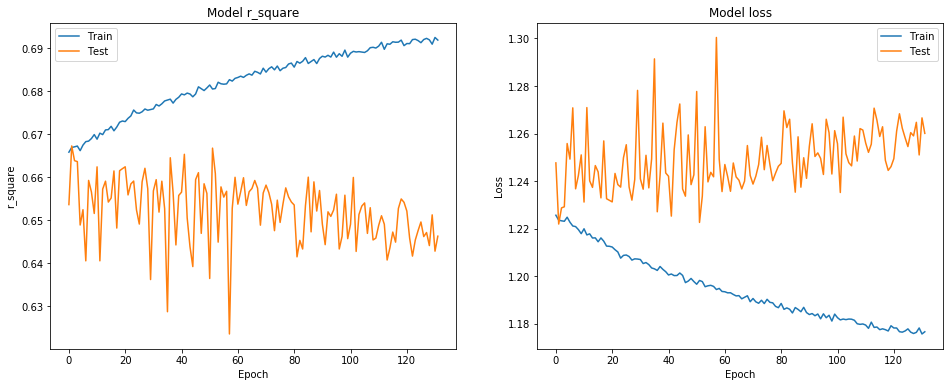

In [29]:
plot_history(fdcnn_rnn_history, 'r_square')
plt.show();